___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

# WELCOME!

Welcome to ***"Demand Prediction Project"***. This is the third capstone project.
As you know recently, free or affordable access to bicycles has been provided for short-distance trips in an urban area as an alternative to motorized public transport or private vehicles. Thus, it is aimed to reduce traffic congestion, noise and air pollution.

In this project, the goal is to predict the number of future bike shares given the historical data of London bike shares. So this case should be handled as a time series problem with ***Bidirectional LSTM***. 

In order to achieve this goal, you will make predictions with LSTM, unlike the machine learning algorithms you have applied before. Long short term memory (LSTM) is an artificial repetitive neural network architecture used in the field of deep learning. Unlike standard feed forward neural networks, LSTM has feedback links. It can process not only single data points but also entire data series. 

Before diving into the project, please take a look at the Determines and Tasks.

- **NOTE:** This tutorial assumes that you already know the basics of coding in Python and are familiar with the theory behind LSTM.



---
---

# #Determines

#### Features

- timestamp - timestamp field for grouping the data
- cnt - the count of a new bike shares
- t1 - real temperature in C
- t2 - temperature in C “feels like”
- hum - humidity in percentage
- wind_speed - wind speed in km/h
- weather_code - category of the weather
- is_holiday - boolean field - 1 holiday / 0 non holiday
- is_weekend - boolean field - 1 if the day is weekend
- season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.


---

Initially, the task of discovering data will be waiting for you as always. Recognize features, detect missing values, outliers etc.

Review the data from various angles in different time breakdowns. For example, visualize the distribution of bike shares by day of the week. With this graph, you will be able to easily observe and make inferences how people's behavior changes daily. Likewise, you can make hourly, monthly, seasonally etc. analyzes. In addition, you can analyze correlation of variables with a heatmap.

In the Pre-Processing task after train test split and robust scaling, the challenge for you will be to divide the data into time steps and transform it into a three dimentional numpy array.

Then in the model building task, build your model appropriate and compare the train and validation losses using a graph. 

When making prediction, you will need to do the inverse transform process to get a true error score. Otherwise, the results you get with scaled target variables may mislead you.

Finally, Visualize how well your model's predictions match the actual values of the test data and also calculate error scores.


- ***Note:*** *What you can do in this project is more than what is asked of you.*


# #Tasks

#### 1. Exploratory Data Analysis

- Check Missing Values and Outliers
- Plot Breakdowns of Data

    *i.  Plot bike shares over time*
    
    *ii.  Plot bike shares by months*
    
    *iii. Plot bike shares by hours*
    
    *iv. Plot bike shares by day of week*
    
    *v. Plot the distribution of bike shares on holidays by seasons*
    
- Drop unnecessary columns
    
#### 2. Data Pre-Processing

- Train - Test Split
- Scaling
- Define a Function for Creating Time Steps

#### 3. Model Building with LSTM

- Create, Compile and Fit Bidirectional LSTM Model
- Plot Train and Validation Losses

#### 4. Demand Prediction and Calculate Scores

- Inverse Transform
- Plot Prediction


## Improt Libraries and Indest Data

In [1]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

In [2]:
df = pd.read_csv("store_sharing.csv")

# df = pd.read_csv("store_sharing.csv",
#                    index_col='DATE',
#                    parse_dates=True)

## Some Useful User Defined Functions

In [3]:
# To view summary information about the column

def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

In [4]:
# Function for determining the number and percentages of missing values

def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [5]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.000,2.000,93.000,6.000,3.000,0.000,1.000,3.000
1,2015-01-04 01:00:00,138,3.000,2.500,93.000,5.000,1.000,0.000,1.000,3.000
2,2015-01-04 02:00:00,134,2.500,2.500,96.500,0.000,1.000,0.000,1.000,3.000
3,2015-01-04 03:00:00,72,2.000,2.000,100.000,0.000,1.000,0.000,1.000,3.000
4,2015-01-04 04:00:00,47,2.000,0.000,93.000,6.500,1.000,0.000,1.000,3.000


In [6]:
df.tail()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
17409,2017-01-03 19:00:00,1042,5.000,1.000,81.000,19.000,3.000,0.000,0.000,3.000
17410,2017-01-03 20:00:00,541,5.000,1.000,81.000,21.000,4.000,0.000,0.000,3.000
17411,2017-01-03 21:00:00,337,5.500,1.500,78.500,24.000,4.000,0.000,0.000,3.000
17412,2017-01-03 22:00:00,224,5.500,1.500,76.000,23.000,4.000,0.000,0.000,3.000
17413,2017-01-03 23:00:00,139,5.000,1.000,76.000,22.000,2.000,0.000,0.000,3.000


In [7]:
df.sample(5)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
11769,2016-05-11 06:00:00,646,15.000,15.000,94.000,12.000,3.000,0.000,0.000,0.000
17171,2016-12-24 21:00:00,218,10.500,9.000,74.000,26.000,2.000,0.000,1.000,3.000
9588,2016-02-09 16:00:00,1349,7.000,3.000,53.000,23.000,2.000,0.000,0.000,3.000
1319,2015-02-28 01:00:00,295,7.000,4.000,76.000,17.000,3.000,0.000,1.000,3.000
5822,2015-09-04 05:00:00,131,12.500,12.500,74.500,13.000,2.000,0.000,0.000,2.000


---
---

## 1. Exploratory Data Analysis

- Firstly, focus data based on the timestamp. You can create various variables such as, hour, day of week, day of month etc.
- You can check missing values and outliers.
- Also you can plot breakdowns of data.

#### 1. Exploratory Data Analysis

- Check Missing Values and Outliers
- Plot Breakdowns of Data

    *i.  Plot bike shares over time*
    
    *ii.  Plot bike shares by months*
    
    *iii. Plot bike shares by hours*
    
    *iv. Plot bike shares by day of week*
    
    *v. Plot the distribution of bike shares on holidays by seasons*
    
- Drop unnecessary columns

### Check Missing Values and Outliers

In [8]:
first_looking('timestamp')

column name    :  timestamp
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  17414
2015-04-11 11:00:00    1
2016-11-25 05:00:00    1
2015-07-10 09:00:00    1
2016-09-12 13:00:00    1
2016-03-29 23:00:00    1
                      ..
2016-02-08 06:00:00    1
2015-05-26 04:00:00    1
2016-06-15 11:00:00    1
2016-10-01 01:00:00    1
2016-01-01 08:00:00    1
Name: timestamp, Length: 17414, dtype: int64


In [9]:
first_looking('cnt')

column name    :  cnt
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  3781
46      46
53      39
120     36
70      36
33      36
        ..
2809     1
2793     1
2697     1
4714     1
2047     1
Name: cnt, Length: 3781, dtype: int64


In [10]:
first_looking('t1')

column name    :  t1
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  73
13.000    969
12.000    822
9.000     807
14.000    802
11.000    779
10.000    753
16.000    729
15.000    719
8.000     714
7.000     684
17.000    570
6.000     562
18.000    490
5.000     472
19.000    449
4.000     377
20.000    358
13.500    316
15.500    307
14.500    297
12.500    293
17.500    288
16.500    288
11.500    286
10.500    283
8.500     271
9.500     261
3.000     249
7.500     241
21.000    240
18.500    236
6.500     210
19.500    199
22.000    173
2.000     169
20.500    166
5.500     160
21.500    150
4.500     136
23.000    130
22.500    123
1.000     111
3.500      94
24.000     83
2.500      79
23.500     71
25.000     53
24.500     50
1.500      39
26.000     38
25.500     36
0.000      34
26.500     28
0.500      24
-1.000     23
27.000     17
-0.500     16
27.500     12
28.000     12
30.000     10
28.500     10
29.000      9
29.500      7

In [11]:
first_looking('t2')

column name    :  t2
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  82
13.000    969
12.000    821
14.000    802
11.000    774
16.000    729
15.000    719
17.000    570
6.000     509
5.000     508
7.000     497
18.000    490
19.000    449
4.000     439
8.000     411
3.000     384
20.000    358
2.000     339
5.500     328
21.000    319
4.500     316
13.500    316
15.500    307
3.500     298
14.500    297
12.500    293
17.500    288
16.500    288
6.500     287
1.000     285
11.500    284
7.500     246
18.500    236
0.000     232
2.500     213
19.500    199
1.500     193
9.000     187
9.500     174
20.500    168
22.000    155
-1.000    148
8.500     143
21.500    139
10.000    123
23.000    118
22.500    109
0.500     109
-0.500    109
-2.000     86
24.000     76
-1.500     73
23.500     63
25.000     50
24.500     48
26.000     41
-2.500     39
10.500     38
-3.000     31
25.500     30
-3.500     19
27.500     18
27.000     18
26.500     18

In [12]:
first_looking('hum')

column name    :  hum
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  143
88.000     965
82.000     928
77.000     774
87.000     710
76.000     513
81.000     489
72.000     450
94.000     422
71.000     414
85.000     371
79.500     369
83.000     337
93.000     336
74.500     322
66.000     319
91.000     300
68.000     287
67.000     275
62.000     258
73.500     258
64.000     253
63.000     247
59.000     243
61.000     241
78.000     240
70.000     230
90.000     227
75.000     215
69.500     203
78.500     199
65.000     195
84.000     190
56.000     188
60.000     184
57.000     178
58.000     177
73.000     174
68.500     161
85.500     151
53.000     149
84.500     148
55.000     144
79.000     134
54.000     128
72.500     120
69.000     118
50.000     105
80.500     102
75.500     101
100.000    100
52.000      96
49.000      95
80.000      89
46.000      88
70.500      87
47.500      83
50.500      83
44.000      82
63.500   

In [13]:
first_looking('wind_speed')

column name    :  wind_speed
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  103
12.000    842
11.000    832
14.000    832
15.000    828
13.000    828
16.000    803
10.000    707
17.000    705
9.000     672
18.000    614
8.000     587
19.500    572
6.500     550
7.000     468
22.000    461
6.000     405
24.000    403
5.000     398
23.000    396
21.000    378
19.000    360
26.000    343
25.000    333
18.500    330
20.000    322
20.500    275
27.000    234
7.500     231
28.000    204
4.000     198
2.000     175
30.500    145
29.000    142
21.500    130
5.500     126
3.000     106
29.500    104
17.500    100
30.000     87
33.000     81
32.000     77
8.500      75
34.000     70
0.000      68
31.500     68
35.000     66
31.000     64
28.500     54
38.000     44
36.000     44
22.500     38
16.500     36
37.000     36
32.500     34
39.000     30
27.500     27
9.500      24
23.500     21
40.000     20
3.500      18
15.500     17
26.500     14
41.0

In [14]:
first_looking('weather_code')

column name    :  weather_code
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  7
1.000     6150
2.000     4034
3.000     3551
7.000     2141
4.000     1464
26.000      60
10.000      14
Name: weather_code, dtype: int64


In [15]:
first_looking('is_holiday')

column name    :  is_holiday
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
0.000    17030
1.000      384
Name: is_holiday, dtype: int64


In [16]:
first_looking('is_weekend')

column name    :  is_weekend
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
0.000    12444
1.000     4970
Name: is_weekend, dtype: int64


In [17]:
first_looking('season')

column name    :  season
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4
0.000    4394
1.000    4387
3.000    4330
2.000    4303
Name: season, dtype: int64


In [18]:
missing (df)

,Missing_Number,Missing_Percent
timestamp,0,0.000
cnt,0,0.000
t1,0,0.000
t2,0,0.000
hum,0,0.000
wind_speed,0,0.000
weather_code,0,0.000
is_holiday,0,0.000
is_weekend,0,0.000
season,0,0.000


In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cnt,17414.000,1143.102,1085.108,0.000,257.000,844.000,1671.750,7860.000
t1,17414.000,12.468,5.572,-1.500,8.000,12.500,16.000,34.000
t2,17414.000,11.521,6.615,-6.000,6.000,12.500,16.000,34.000
hum,17414.000,72.325,14.313,20.500,63.000,74.500,83.000,100.000
wind_speed,17414.000,15.913,7.895,0.000,10.000,15.000,20.500,56.500
weather_code,17414.000,2.723,2.341,1.000,1.000,2.000,3.000,26.000
is_holiday,17414.000,0.022,0.147,0.000,0.000,0.000,0.000,1.000
is_weekend,17414.000,0.285,0.452,0.000,0.000,0.000,1.000,1.000
season,17414.000,1.492,1.119,0.000,0.000,1.000,2.000,3.000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [21]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace = True)

df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.000,2.000,93.000,6.000,3.000,0.000,1.000,3.000
2015-01-04 01:00:00,138,3.000,2.500,93.000,5.000,1.000,0.000,1.000,3.000
2015-01-04 02:00:00,134,2.500,2.500,96.500,0.000,1.000,0.000,1.000,3.000
2015-01-04 03:00:00,72,2.000,2.000,100.000,0.000,1.000,0.000,1.000,3.000
2015-01-04 04:00:00,47,2.000,0.000,93.000,6.500,1.000,0.000,1.000,3.000


In [22]:
from datetime import datetime

df["year_month"] = df.index.strftime('%Y-%m')
df["year"] = df.index.year
df["month"] = df.index.month
df["day_of_month"] = df.index.day
df["day_of_week"] = df.index.day_of_week
df["hour"] = df.index.hour

df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year_month,year,month,day_of_month,day_of_week,hour
timestamp,,,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.000,2.000,93.000,6.000,3.000,0.000,1.000,3.000,2015-01,2015,1,4,6,0
2015-01-04 01:00:00,138,3.000,2.500,93.000,5.000,1.000,0.000,1.000,3.000,2015-01,2015,1,4,6,1
2015-01-04 02:00:00,134,2.500,2.500,96.500,0.000,1.000,0.000,1.000,3.000,2015-01,2015,1,4,6,2
2015-01-04 03:00:00,72,2.000,2.000,100.000,0.000,1.000,0.000,1.000,3.000,2015-01,2015,1,4,6,3
2015-01-04 04:00:00,47,2.000,0.000,93.000,6.500,1.000,0.000,1.000,3.000,2015-01,2015,1,4,6,4


### Plot Breakdowns of Data

***i. Plot bike shares over time***

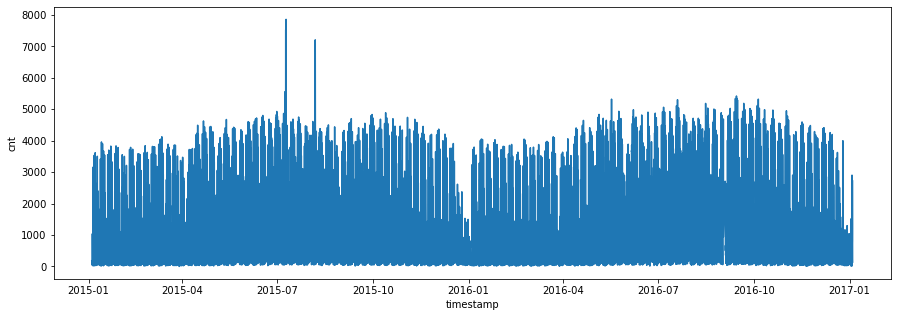

In [23]:
plt.figure(figsize=(15,5))
sns.lineplot(data = df, x = df.index, y = "cnt")

plt.show()

***ii. Plot bike shares by months***

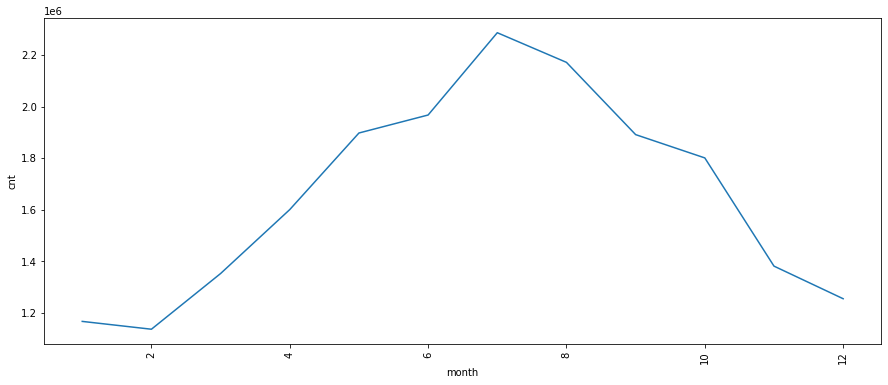

In [24]:
plt.figure(figsize = (15,6))
sns.lineplot(data = df, x = "month", y = "cnt", estimator = 'sum', ci = None)
plt.xticks(rotation = 90);

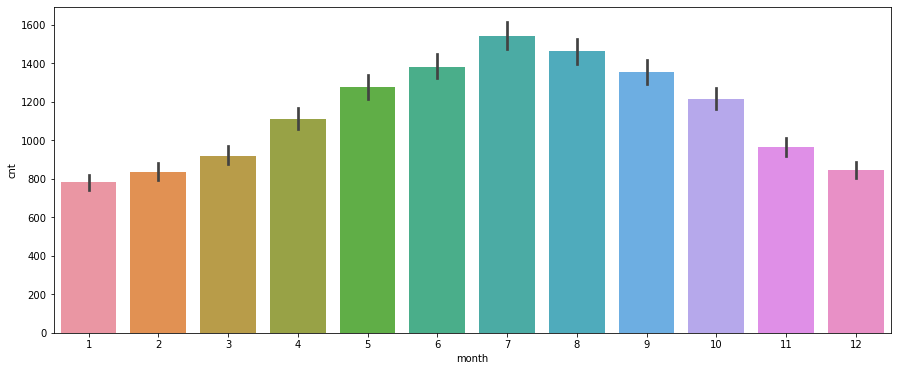

In [25]:
plt.figure(figsize=(15,6))
sns.barplot(data = df, x = "month", y = "cnt");

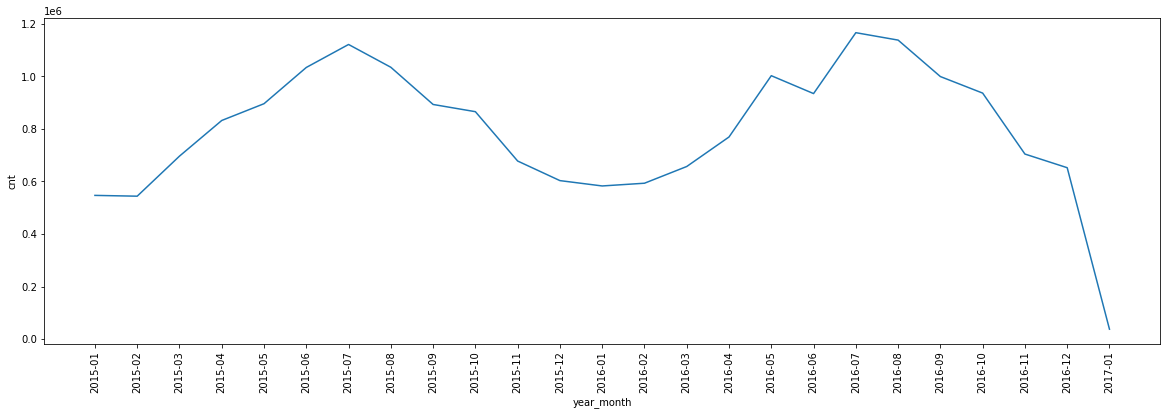

In [26]:
plt.figure(figsize = (20,6))

sns.lineplot(data = df, x = "year_month", y = "cnt", estimator = 'sum', ci = None)
plt.xticks(rotation = 90)

plt.show()

***iii. Plot bike shares by hours***
- *whether it is a holiday or not*
- *You may want to see seasonal breakdowns*

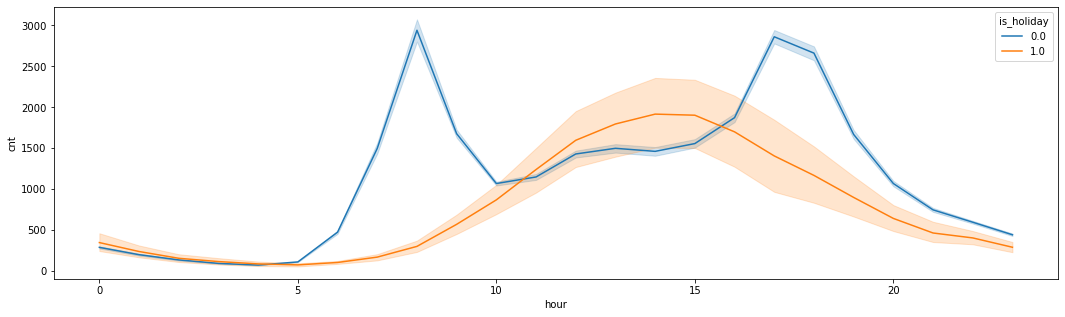

In [27]:
plt.figure(figsize=(18,5))
sns.lineplot(data = df, x = "hour", y = "cnt", hue = "is_holiday")
plt.show()

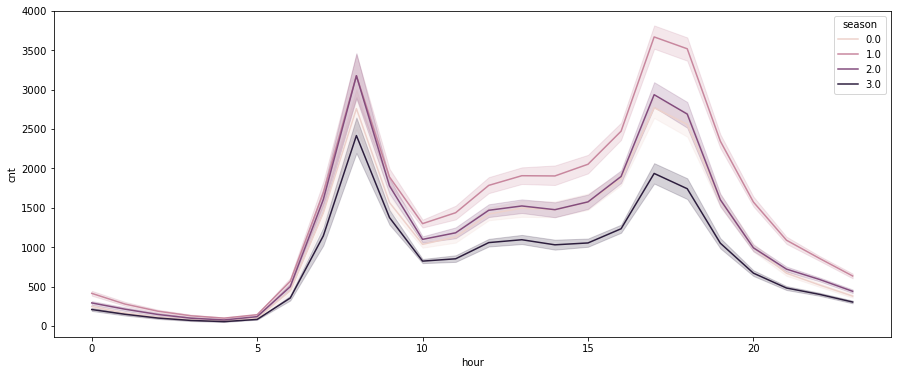

In [28]:
plt.figure(figsize=(15,6))
sns.lineplot(data = df, x = "hour", y = "cnt", hue = "season")
plt.show()

***iv. Plot bike shares by day of week***
- *You may want to see seasonal breakdowns*

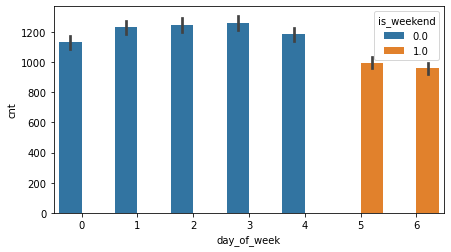

In [29]:
plt.figure(figsize=(7,3.8))
sns.barplot(data = df, x = "day_of_week", y = "cnt", hue = "is_weekend")
plt.show()

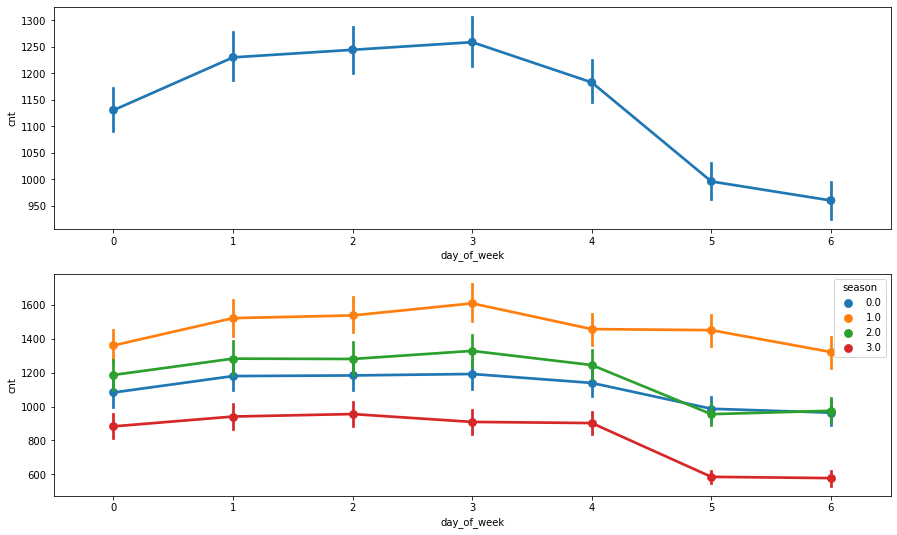

In [30]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15,9))
sns.pointplot(data = df, x = "day_of_week", y = "cnt", ax = ax[0])
sns.pointplot(data = df, x = "day_of_week", y = "cnt", hue = "season", ax = ax[1])
plt.show()

***v. Plot the distribution of bike shares on holidays by seasons***

In [31]:
df.groupby(["season","is_holiday"])["cnt"].sum()

season  is_holiday
0.000   0.000         4678625
        1.000          171611
1.000   0.000         6380794
        1.000           43815
2.000   0.000         5073040
3.000   0.000         3478015
        1.000           80072
Name: cnt, dtype: int64

In [32]:
df.groupby("season")["cnt"].count()

season
0.000    4394
1.000    4387
2.000    4303
3.000    4330
Name: cnt, dtype: int64

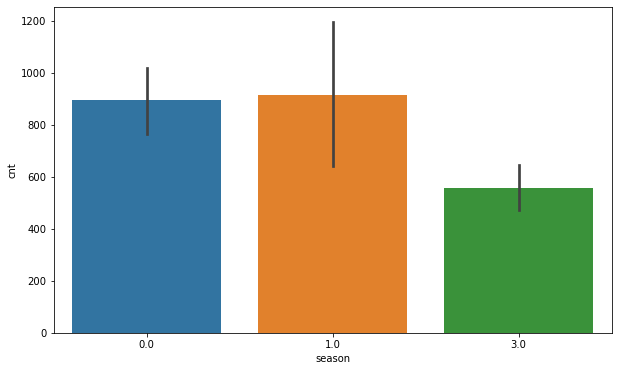

In [33]:
is_holiday = df[df.is_holiday == 1.0]
sns.barplot(data = is_holiday, x = "season", y = "cnt");

### Drop unnecessary columns

- Check correlations via heatmap
- Check weather_code
- Think about time-based features and decide dropping which is unnecessary for the model

<AxesSubplot:>

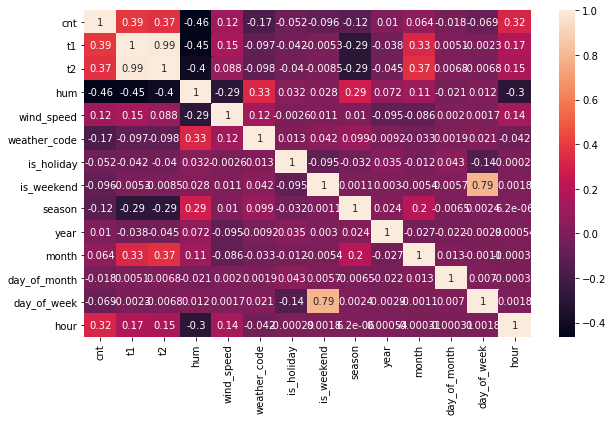

In [34]:
sns.heatmap(df.corr(), annot=True)

In [35]:
df_temp = df.corr()

count = "Done"
feature =[]
collinear=[]
for col in df_temp.columns:
    for i in df_temp.index:
        if (df_temp[col][i]> .9 and df_temp[col][i] < 1) or (df_temp[col][i]< -.9 and df_temp[col][i] > -1) :
                feature.append(col)
                collinear.append(i)
                print(Fore.RED + f"\033[1mmulticolinearity alert in between\033[0m {col} - {i}")
        else:
            print(f"For {col} and {i}, there is NO multicollinearity problem") 

print("\033[1mThe number of strong corelated features:\033[0m", count) 

For cnt and cnt, there is NO multicollinearity problem
For cnt and t1, there is NO multicollinearity problem
For cnt and t2, there is NO multicollinearity problem
For cnt and hum, there is NO multicollinearity problem
For cnt and wind_speed, there is NO multicollinearity problem
For cnt and weather_code, there is NO multicollinearity problem
For cnt and is_holiday, there is NO multicollinearity problem
For cnt and is_weekend, there is NO multicollinearity problem
For cnt and season, there is NO multicollinearity problem
For cnt and year, there is NO multicollinearity problem
For cnt and month, there is NO multicollinearity problem
For cnt and day_of_month, there is NO multicollinearity problem
For cnt and day_of_week, there is NO multicollinearity problem
For cnt and hour, there is NO multicollinearity problem
For t1 and cnt, there is NO multicollinearity problem
For t1 and t1, there is NO multicollinearity problem
multicolinearity alert in between t1 - t2
For t1 and hum, there is NO m

In [36]:
df["weather_code"].value_counts()

1.000     6150
2.000     4034
3.000     3551
7.000     2141
4.000     1464
26.000      60
10.000      14
Name: weather_code, dtype: int64

"weather_code" category description:
- 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
- 2 = scattered clouds / few clouds 
- 3 = Broken clouds 
- 4 = Cloudy 
- 7 = Rain/ light Rain shower/ Light rain 
- 10 = rain with thunderstorm 
- 26 = snowfall 

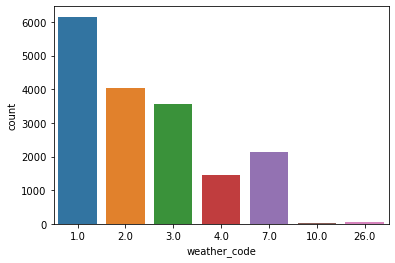

In [37]:
plt.figure(figsize=(6,4))
sns.countplot(x = "weather_code", data = df)
plt.show()

<Figure size 432x288 with 0 Axes>

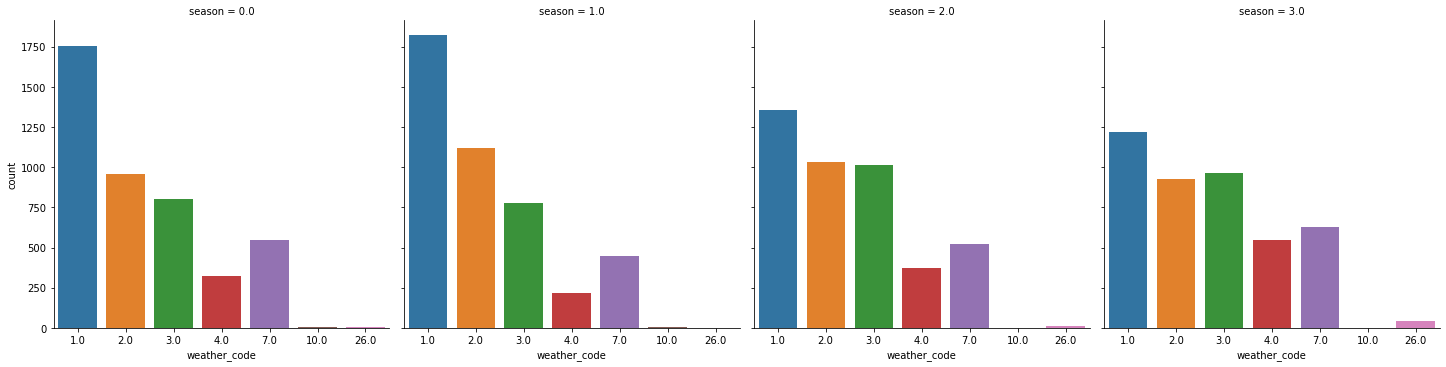

In [38]:
plt.figure(figsize=(6,4))
sns.catplot(x = "weather_code", col = "season", col_wrap = 4, data = df, kind="count")
plt.show()

In [39]:
# drop unnecessary columns

In [40]:
df.shape

(17414, 15)

In [41]:
drop_columns = ["t1","year_month"]

In [42]:
df.drop(drop_columns, axis=1, inplace=True)

In [43]:
df.shape

(17414, 13)

In [44]:
df.head()

,cnt,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day_of_month,day_of_week,hour
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,2.000,93.000,6.000,3.000,0.000,1.000,3.000,2015,1,4,6,0
2015-01-04 01:00:00,138,2.500,93.000,5.000,1.000,0.000,1.000,3.000,2015,1,4,6,1
2015-01-04 02:00:00,134,2.500,96.500,0.000,1.000,0.000,1.000,3.000,2015,1,4,6,2
2015-01-04 03:00:00,72,2.000,100.000,0.000,1.000,0.000,1.000,3.000,2015,1,4,6,3
2015-01-04 04:00:00,47,0.000,93.000,6.500,1.000,0.000,1.000,3.000,2015,1,4,6,4


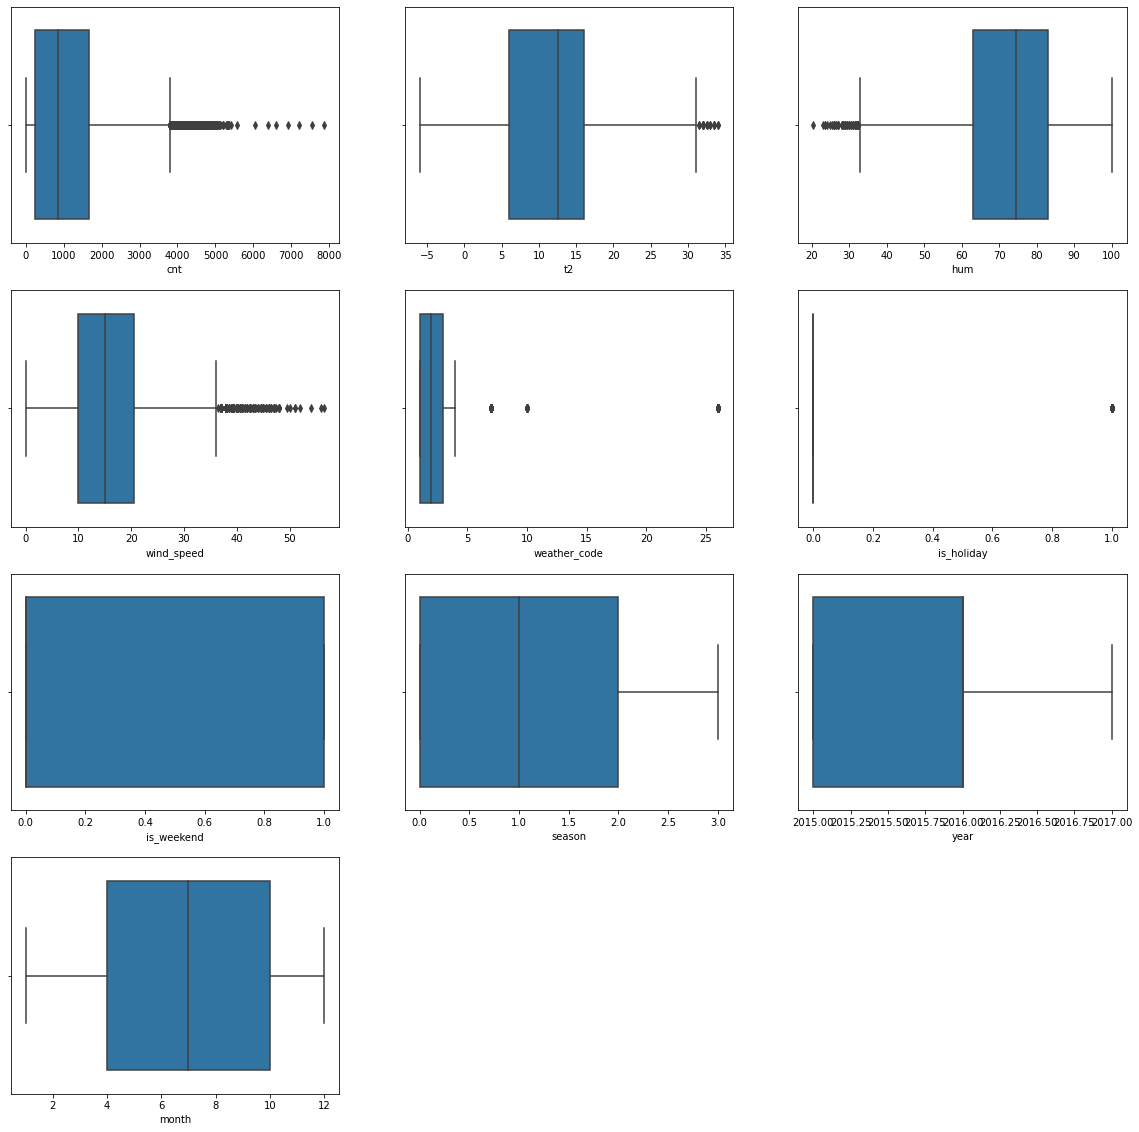

In [45]:
index = 0
plt.figure(figsize=(20,20))
for col in df.columns[:10]:
    index += 1
    plt.subplot(4,3,index)
    sns.boxplot(x=col, data=df, whis=1.5)

## 2. Data Pre-Processing


### Train - Test Split

Appropriately split the data for optimum training.

### Scaling

**Robust Scaling**

It is common to scale data prior to fitting a machine learning model.

This is because data often consists of many different input variables or features (columns) and each may have a different range of values or units of measure, such as feet, miles, kilograms, dollars, etc.

If there are input variables that have very large values relative to the other input variables, these large values can dominate or skew some machine learning algorithms. The result is that the algorithms pay most of their attention to the large values and ignore the variables with smaller values.

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. You can easily normalize the dataset using the Robust Scaling preprocessing class from the scikit-learn library.

- ***Note:*** *You are expected to scale only 't1'/'t2', 'hum', 'wind_speed' variables. You also need to scale the dependent and independent variables separately. You must do this for both train data and test data.*

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
f_columns = ['t1', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

### Define a Function for Creating Time Steps 

In order to use the capabilities of LSTM, we need to organize the data in accordance with the working principles of LSTM.
You must separate the lines ordered by time in decimal steps.
The size of the step may vary depending on the situation, in this case it is set to 10.

Therefore, train and test data should be divided into groups of ten.
When predicting test data, the model is asked to use the information from the next 10 records with itself for each record.

As a result of this operation, each row will create a time step with the next 10 records, and you will have a matrix consisting of steps as many as the row total at the beginning.
So, your data set must be a 3-dimensional numpy array like (15662, 10,13).
As a result, LSTM will learn by taking 10 rows into account for one row.

Create a function, that takes two arguments: the dataset(dependent or independent variables separately), which is a NumPy array that we want to convert into a dataset, and the time_steps, which is the number of previous time steps to use as input variables to predict the next time period.

After defining the function, apply it to train and test sets.

In [ ]:
def create_dataset(X, y, time_steps=1):
    """ Create data sequence
    
    Arguments:
        * X: time-series data
        * y: Count "cnt" value
        * time_steps: Used to create input sequence of timesteps
    
    Returns:
        * input_sequence: Numpy array of sequences of time-series data
        * output: Numpy array of output i.e. next value for respective sequence
    
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys) #x = np.asarray(x).astype('float32').

In [ ]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

---
---

## 3. Model Building with LSTM



##Recurrent Neural Networks 
RNN are a type of artifcial neural network designed to recognize patterns in sequences of data, such as text, genomes, handwriting, the spoken word, numerical times series data.

Recurrent Neural Networks use backpropagation algorithm for training. Because of their internal memory, RNN’s are able to remember important things about the input they received, which enables them to be very precise in predicting what’s coming next.

RNNs could be stacked up to deeper versions, which contain more than 1 layers of RNN. Because RNNs are especially computationally expensive to train, normally a deep RNN model contains no more than 3 layers of LSTM.

Train a bidirectional long short term memory (LSTM) recurrent neural network (RNN) with this data, making use of the self-loop and forget gate of LSTM.

LSTM sequential learning model was chosen because of its ability to process sequential data and memorize data of past time steps.

LSTM is a different type of gated RNN which is capable of learning long-term dependencies LSTM is not affected by vanishing gradient or exploding gradient problem
Using Bidirectional LSTMs, we feed the learning algorithm with the original data once from beginning to the end and once from end to beginning.

#### Bidirectional LSTM :
Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem. Figure shows the mechanism of Bidirectional LSTM.






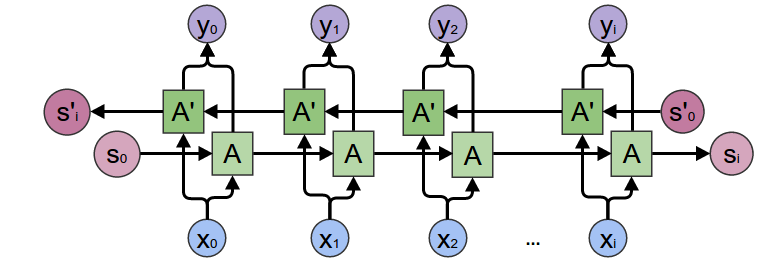

### Create, Compile and Fit Bidirectional LSTM Model

- Create a Sequential Model,
- Add Bidirectional layers,
- Apply Regularization (Drop Out),
- Compile the model.

***Note:*** *Define the optimizer as the efficient stochastic gradient descent algorithm ***adam***.* *This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.*

*In this case, use ***mean squared error*** as the loss argument. This loss is for a regression problems and is defined in Keras as mean_squared_error.
Also use defined in Keras as ***accuracy*** as the metrics.*

### Plot Train and Validation Losses

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]))))

model.add(Dropout(rate=0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=32, 
          validation_split=0.3,
          shuffle=False,
          callbacks=[early_stop])

---
---

## 4. Demand Predictions and Calculate Scores

At this stage, you will measure the prediction success of your model. So, you will need to compare the actual values of the test data with their predicted values. 

For this reason, you must inverse transform the y_pred variable predicted by the model with the target variables of the train and test data you have previously scaled.

Check scores with both scaled results and inversed results

Plot predictions and actula values together

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

### Inverse Transform

In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

In [ ]:
test_index = df_dum.iloc[train_size:].iloc[time_steps:].index

pred_test = pd.concat([pd.DataFrame(y_test_inv.reshape(-1, 1)),
                       pd.DataFrame(y_pred_inv)], axis = 1)
pred_test.columns=['test','prediction']
pred_test.index = test_index

### Plot Prediction

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___